In [49]:
import argparse
from pathlib import Path
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole


In [50]:
import pandas as pd
from tqdm import tqdm
import prolif as plf
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_types
from pathlib import Path

In [51]:
IPythonConsole.ipython_useSVG = True

# Initialize progress bar for pandas
tqdm.pandas()

In [52]:
final_results_df = pd.read_csv('processed/processed.csv')
final_results_df.shape

(34107, 13)

In [53]:
final_results_df.head()

,Residue,Hydrophobic.distance,VdWContact.distance,HBDonor.distance,HBDonor.DHA_angle,Cationic.distance,HBAcceptor.distance,HBAcceptor.DHA_angle,PiStacking.distance,PiStacking.plane_angle,PiStacking.normal_to_centroid_angle,PiStacking.intersect_distance,PDB_File
0,VAL60.A,4.475821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,ASP61.A,NaN,3.103711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,PHE64.A,4.006420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,PHE64.A,NaN,3.348581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,PHE64.A,4.006420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [54]:
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets


### Viewing scaled distributions for 501 pdb files

##### Select from dropdown to view each of the metric in the output

(If you are viewing this in the Constructor Research Platform, the dropdown may not be visible. But it should be visible and clickable if you open the ipynb files in VSCode.

 

Notes:
- Previously this was just a simple histogram distribution of each of the metric (scaled)
- This updated version smoothes the histogram using a Gaussian distribution based on the instructions in the task https://youtrack.constr.dev/issue/SP-16 on YouTrack.

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

Function that takes in as arguments
- dataframe 
- group_ids - list of residue labels to consider 
- columns - list of columns for which we build distributions. For each column we calculate a separate distribution, unless an option "merge_distributions" is set to True. By default we consider all columns, except for the residue column.
- merge_distributions - a boolean flag to merge the distributions (see above). By default it is False
- smooth_distribution - float parameter corresponding to sigma of the gaussian that is applied for each sample. By default is 0 (no smoothening).
- smooth_tolerance - float parameter to neglect the gaussian tails, that is at beyond sigma*smooth_tolerance we consider gaussian as 0.
- bin_size - float parameter to determine the size of the bin
- n_bins - int parameter to determine the number of bins
- range - tuple of (left_border, right_border) to determine the interval of the distribution.

In [56]:
def build_smooth_distribution(dataframe, merge_distributions, group_ids=None, columns=None, smooth_distribution=0, 
                              smooth_tolerance=3, bin_size=0.1, n_bins=50, range=None):
    if group_ids is not None:  
        dataframe = dataframe[dataframe['Residue'].isin(group_ids)] # if no group_ids is specified, we calculate distributions across all residues. If specidied, we filter dataframe for only those residues
    
    if columns is None: # Default case of all columns
        columns = [col for col in dataframe.columns if col != 'Residue']
    
    distributions = {} #Dictionary to store distributions
    
    for column in columns: # Either default case or list of columns we specify
        data = dataframe[column].dropna()
        
        # If the range is not specified, calculate it from the data
        if range is None:
            data_range = (data.min(), data.max())
        else:
            data_range = range
            
        bins = np.linspace(data_range[0], data_range[1], n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Initialize the distribution
        dist = np.zeros(n_bins)
        
        for value in data:
            if smooth_distribution > 0:
                gaussian_contributions = norm.pdf(bin_centers, loc=value, scale=smooth_distribution)
                gaussian_contributions[gaussian_contributions < norm.pdf(smooth_tolerance)] = 0
                dist += gaussian_contributions
            else:
                # Place the value in the appropriate bin without smoothing
                bin_index = np.digitize(value, bins) - 1
                if 0 <= bin_index < len(dist):
                    dist[bin_index] += 1
        dist /= dist.sum() * bin_size  # Normalize the distribution
        
        if merge_distributions: # If we want to merge across columns and multiple columns are specified
            if 'Merged' not in distributions: # For 1st merge
                distributions['Merged'] = dist
            else:
                distributions['Merged'] += dist # Adding next column's distribution
        else: # If we want the distributions separately for each column, output as a dictionary (append to it) with entries for each column
            distributions[column] = dist
    
    return distributions, bin_centers

In [57]:
# Testing for one residue and column in one dataframe
# dataframe = final_results_df
# group_ids= ['VAL60.A']
# columns= ['Hydrophobic.distance']
# smooth_distribution=1
# smooth_tolerance=0.75
# bin_size=0.1
# n_bins=50

In [58]:
columns = ['Hydrophobic.distance','VdWContact.distance']


In [59]:
def process_dataframes(folder, columns, merge_distributions, sliding_window=0):
    file_list = [f for f in os.listdir(folder) if f.endswith('.csv')]
    all_distributions = []
    all_bin_centers = []

    for file in file_list:
        filepath = os.path.join(folder, file)
        df = pd.read_csv(filepath)
        
        distributions, bin_centers = build_smooth_distribution(df, merge_distributions=merge_distributions, columns = columns)
        
        if merge_distributions:
                # Append the merged distribution to the list
                all_distributions.append(distributions['Merged'])
                # Combine all merged distributions into a single plot
                merged_distribution = np.mean(all_distributions, axis=0)
                
                plt.figure(figsize=(10, 6))
                plt.plot(bin_centers, merged_distribution, label='Merged Distribution', color='blue')
                plt.fill_between(bin_centers, merged_distribution, color='blue', alpha=0.2)
                plt.title('Merged Distribution Across All Dataframes')
                plt.xlabel('Value')
                plt.ylabel('Density')
                plt.legend()
                plt.grid(True)
                plt.show()


        else:
            # If not merging, calculate the mean and variance over the distributions
            for col in distributions:
                    all_distributions.append(distributions[col])
                    all_bin_centers.append(bin_centers)
    
            # mean_distribution = np.mean(all_distributions, axis=0)
            # variance_distribution = np.var(all_distributions, axis=0)
            
            # Plotting the results
            for i, col in enumerate(distributions.keys()):
                plt.figure(figsize=(10, 6))
                
                plt.plot(all_bin_centers[i], all_distributions[i], label=f'Distribution of {col}', color='blue')
                if sliding_window:
                    smoothed_distribution = np.convolve(distributions[col], np.ones(sliding_window)/sliding_window, mode='same')
                    plt.plot(all_bin_centers[i], smoothed_distribution, label=f'Smoothed Distribution of {col}', color='orange')
                
                plt.title(f'Distribution of {col} Across Dataframes')
                plt.xlabel('Bins')
                plt.ylabel('Value')
                plt.legend()
                plt.show()

        


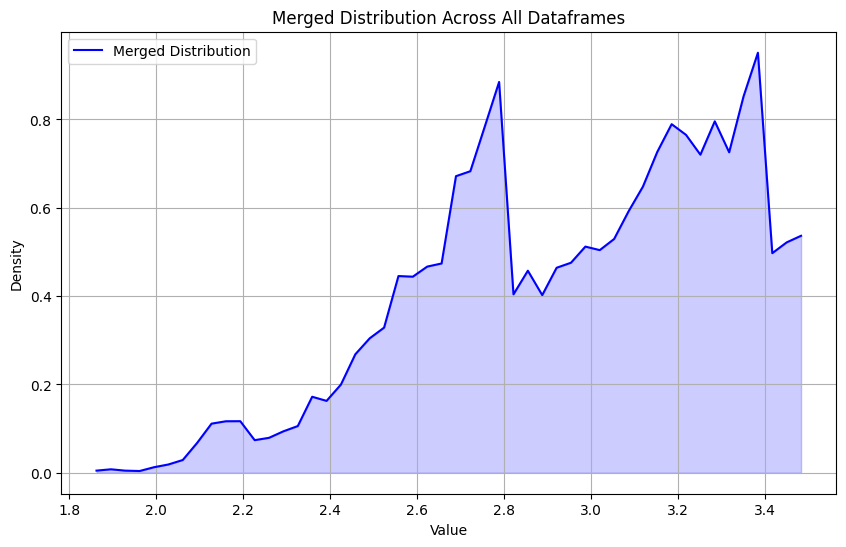

In [60]:
process_dataframes('/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/processed', columns, merge_distributions=True, sliding_window=3)

# <----------- IGNORE THE CODE BELOW FROM PREVIOUS VERSIONS --------->

In [8]:
def plot_normalized_distributions(df, columns):
    @interact(column=columns)
    def make_plot(column):
        all_data = df[column].dropna()
        
        # Ensure there is data to plot
        if all_data.empty:
            print(f"No data available for column {column}")
            return
        
        num_bins = 50
        bin_edges = np.linspace(all_data.min(), all_data.max(), num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]

        std_dev = all_data.std()

        smoothed_counts = np.zeros(num_bins)

        # Gaussian kernel function
        def gaussian_kernel(x, mean, std):
            return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
        
        # Accumulate contributions to each bin from each data point
        for data_point in all_data:
            contributions = gaussian_kernel(bin_centers, data_point, std_dev)
            smoothed_counts += contributions

        # Normalize the smoothed counts
        smoothed_counts /= (smoothed_counts.sum() * bin_width)


        # # Calculate histogram for aggregated data
        # counts, bins = np.histogram(all_data, bins=50, density=True)
        
        # # Normalize the counts by dividing by the number of data points
        # total_count = len(all_data)
        # normalized_counts = counts / total_count
        
        # Plotting
        fig = go.Figure()
        
        fig.add_trace(go.Bar(
            x=bin_centers,  # Bin centers
            y=smoothed_counts,
            name='All PDB Files',
            opacity=0.75,
            marker_color='blue'
        ))

        # fig.add_trace(go.Bar(
        #     x=bins[:-1],  # Bin edges
        #     y=normalized_counts,
        #     name='All PDB Files',
        #     opacity=0.75,
        #     marker_color='blue'
        # ))
        
        fig.update_layout(
            title=f'Normalized Distribution of {column} across All PDB Files',
            xaxis_title=column,
            yaxis_title='Normalized Count',
            barmode='overlay'
        )
        
        # fig.update_layout(
        #     title=f'Normalized Distribution of {column} across All PDB Files',
        #     xaxis_title=column,
        #     yaxis_title='Normalized Count',
        #     barmode='overlay'
        # )
        
        fig.show()

In [9]:
# columns = [col for col in final_results_df.columns if col not in ['PDB_File', 'Residue']]
# plot_normalized_distributions(final_results_df, columns)

numeric_columns = [
    col for col in final_results_df.columns
    if col not in ['PDB_File', 'Residue'] and pd.api.types.is_numeric_dtype(final_results_df[col])
]

plot_normalized_distributions(final_results_df, numeric_columns)

interactive(children=(Dropdown(description='column', options=('Hydrophobic.distance', 'VdWContact.distance', '…

# Distributions for 2nd and 3rd sets of frames

In [10]:
df2 = pd.read_csv('md_conf_snap_2_processed.csv')
numeric_columns2 = [
    col for col in df2.columns
    if col not in ['PDB_File', 'Residue'] and pd.api.types.is_numeric_dtype(df2[col])
]
plot_normalized_distributions(df2, numeric_columns2)

interactive(children=(Dropdown(description='column', options=('Hydrophobic.distance', 'VdWContact.distance', '…

In [11]:
df3 = pd.read_csv('md_conf_snap_4_processed.csv')
numeric_columns3 = [
    col for col in df3.columns
    if col not in ['PDB_File', 'Residue'] and pd.api.types.is_numeric_dtype(df3[col])
]
plot_normalized_distributions(df3, numeric_columns3)

interactive(children=(Dropdown(description='column', options=('Hydrophobic.distance', 'VdWContact.distance', '…

#### Mean and confidence interval 
##### Smoothed with a rolling window of 25 

In [12]:
def plot_mean_with_confidence_intervals(df, numeric_columns, window_size=5):
    @interact(column=numeric_columns)
    def make_plot(column):
        grouped = df.groupby('PDB_File')[column]
        means = grouped.mean()
        sems = grouped.sem()  # Standard error of the mean

        # Apply moving average to smooth the mean and confidence intervals
        smoothed_means = means.rolling(window=window_size, center=True).mean()
        smoothed_upper = (means + sems).rolling(window=window_size, center=True).mean()
        smoothed_lower = (means - sems).rolling(window=window_size, center=True).mean()

        fig = go.Figure()

        # Add smoothed mean line
        fig.add_trace(go.Scatter(
            x=smoothed_means.index,
            y=smoothed_means.values,
            mode='lines+markers',
            name='Mean (Smoothed)',
            line=dict(color='blue')
        ))

        # Add smoothed confidence interval
        fig.add_trace(go.Scatter(
            x=smoothed_upper.index,
            y=smoothed_upper.values,
            fill=None,
            mode='lines',
            line=dict(color='lightblue'),
            showlegend=True,
            name='Confidence Interval Upper (Smoothed)'
        ))

        fig.add_trace(go.Scatter(
            x=smoothed_lower.index,
            y=smoothed_lower.values,
            fill='tonexty',  # Fill the area between this trace and the previous one
            mode='lines',
            line=dict(color='lightblue'),
            name='Confidence Interval Lower (Smoothed)'
        ))

        fig.update_layout(
            title=f'Mean and Confidence Interval of {column} across PDB Files (Smoothed)',
            xaxis_title='PDB File',
            yaxis_title=column,
            legend_title='Legend'
        )

        fig.show()

In [13]:
numeric_columns = [
    col for col in final_results_df.columns
    if col not in ['PDB_File', 'Residue'] and pd.api.types.is_numeric_dtype(final_results_df[col])
]

# Plot with a default window size for the moving average
plot_mean_with_confidence_intervals(final_results_df, numeric_columns, window_size=25)

interactive(children=(Dropdown(description='column', options=('Hydrophobic.distance', 'VdWContact.distance', '…